# Fera formidável 1: Quem classifica a classe classificadora?

**Autores:** Adrian Paz e Gabriel Viégas

**Objetivo:**  altere a rede neural feita em Python puro para resolver um problema de classificação. Treine uma rede neural em um dataset simples de classificação para mostrar que funciona.

**Comentário:**  aqui é necessário se informar sobre as diferenças de uma rede neural classificadora com relação a uma rede neural regressora. A função de perda, por exemplo, não poderá ser mais a função de perda dos resíduos quadrados.

**Comentário 2:**  observe que o enunciado diz claramente que é para realizar a tarefa na rede neural feita em Python puro nos vídeos da disciplina. Se você está usando o ``PyTorch``, ``numpy``, ``tensorflow``, ``keras``, ``lightning`` ou qualquer outra biblioteca pronta, você está no caminho errado!

# Resolução:

## Adaptação da rede regressora para a rede classificadora

Nossa resolução foi baseada na aula disponibilizada pelo *Dataquest* no YouTube: [Classification With Neural Networks](https://www.youtube.com/watch?v=71GtdWmznok).

Primeiro, realizamos as importações relevantes para a tarefa.

In [1]:
# Importações relevantes
import math
import random
tol = 1e-3

Nas redes neurais de classificação binária, a saída deve ser um número entre 0 e 1, de maneira que números mais próximos de 1 vão indicar maior adequação dos dados à classe 1, e vice-versa. O quão próximo de um dos extremos indica a "certeza" que a rede neural tem da sua classificação: uma saída de 0.79 representa menos certeza de pertencer à classe 1 que uma saída de 0.99.

Para "forçar" a saída a apresentar valores entre 0 e 1, é possível usar funções de ativação na última camada oculta que normalizam a saída de maneira que ela assuma valores de 0 a 1. Uma das mais triviais é a função sigmoidal, já vista anteriormente na disciplina, e a escolhida para esse projeto. Para as demais camadas, utilizamos ReLU, uma função comumente utilizada em redes neurais hoje em dia.

Assim, assumindo que no tratamento de dados transformaremos os atributos e o *target* em números, a única parte que precisamos mudar na rede neural é a última função de ativação na classe MLP. Abaixo, o trecho de código alterado:

```
def __call__(self, x, tipo_ativacao='sig'):
    for camada in self.camadas[:-1]:
        x = camada(x, tipo_ativacao='relu') # transforma x a cada camada chamada
        camada_final = self.camadas[-1]
        x = camada_final(x, tipo_ativacao)
```

Abaixo, as classes necessárias para o funcionamento da rede.

In [2]:
class Value:
    def __init__(self, data, parents=(), parent_operator='', label=''):
        if isinstance(data, Value):
            self.data = data.data
        else:
            self.data = data
        self.parents = parents
        self.parent_operator = parent_operator
        self.label = label
        self.grad = tol

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other_value):
        """self + other_value"""

        if not isinstance(other_value, Value):
            other_value = Value(other_value)

        parent_operator = "+"
        parents = (self, other_value)
        data = self.data + other_value.data

        result = Value(data, parents, parent_operator)

        def propagate_add():
            self.grad += result.grad * 1 # grad filho * derivada filho em relação a mãe
            other_value.grad += result.grad * 1

        result.propagate = propagate_add # sobrescreve a função de propagar do vértice filho

        return result

    def __radd__(self, other_value):
        """other_value + self"""

        return self + other_value

    def __sub__(self, other_value):
        """self - other_value"""
        return self + (- other_value)

    def __rsub__(self, other_value):
        return other_value + (-self)

    def __mul__(self, other_value):
        """self * other_val"""

        if not isinstance(other_value, Value):
            other_value = Value(other_value)

        parent_operator = "*"
        parents = (self, other_value)
        data = self.data * other_value.data

        result = Value(data, parents, parent_operator)

        def propagate_mul():
            self.grad += result.grad * other_value.data # grad filho * derivada filho em rel. mae
            other_value.grad += result.grad * self.data

        result.propagate = propagate_mul

        return result

    def __rmul__(self, other_value):
        """other_val * self"""
        return self * other_value

    def __pow__(self, exponential):
        """self ** expoente"""

        # certificando-se que o expoente é um inteiro ou float
        assert isinstance(exponential, (int, float))

        parent_operator = f"**{exponential}"
        parents = (self, )
        data = self.data ** exponential

        result = Value(data, parents, parent_operator)

        def propagate_pow():
            self.grad += result.grad * (exponential * self.data ** (exponential - 1))

        result.propagate = propagate_pow

        return result

    def __eq__(self, other_val):
        if not isinstance(other_val, Value):
          assert isinstance(other_val, (float, int))
          other_val = Value(other_val)

        return self.data == other_val.data

    def __gt__(self, other_val):
        if not isinstance(other_val, Value):
          assert isinstance(other_val, (float, int))
          other_val = Value(other_val)

        return self.data > other_val.data

    def __lt__(self, other_val):
      if not isinstance(other_val, Value):
        assert isinstance(other_val, (float, int))
        other_val = Value(other_val)

      return self.data < other_val.data

    def __truediv__(self, other_value):
        """self / other_value"""

        return self * (other_value ** (-1))

    def __rtruediv__(self, other_val):
        if not isinstance(other_val, Value):
            assert isinstance(other_val, (float, int))
            other_val = Value(other_val)

        return other_val / self

    def __neg__(self):
        """ - self """
        return self * (-1)

    def __hash__(self):
        return id(self)

    def exp(self, d = None):
        """exp(self)"""

        parent_operator = "exp"
        parents = (self,)
        data = math.exp(self.data)

        result = Value(data, parents, parent_operator)

        def propagate_exp():
            self.grad += result.grad * data

        result.propagate = propagate_exp

        return result

    def sig(self):
        """exp(self) / (exp(self) + 1)"""

        return self.exp() / (self.exp() + 1)

    def relu(self):
        """max(0, self)"""

        parent_operator = "relu"
        parent = (self, )
        data = max(0, self.data)
        result = Value(data, parent, parent_operator)

        def propagate_relu():
            self.grad += (1.0 if self.data > 0 else 0.0) * result.grad

        result.propagate = propagate_relu
        return result

    def log(self, base=math.e):
        """log(self)"""

        # certificando-se que a base é um inteiro ou float positivo
        assert isinstance(base, (int, float))
        assert base > 0
        assert self.data + tol > 0

        parent_operator = f"log{base}"
        parents = (self, )
        data = math.log(self.data, base)

        result = Value(data, parents, parent_operator)

        def propagate_log():
            if data == 0:
                self.grad = 0
            else:
                self.grad += result.grad * (1 / self.data * math.log(base + tol)) # gradiente filho * derivada filho em rel. mae

        result.propagate = propagate_log

        return result

    def softplus(self):
        """ln(1 + exp(self))"""

        return self.log((1 + self.exp()))

    def swish(self, beta=1):
        """self * (1 + exp(-beta * self))^-1"""

        assert isinstance(beta, (int, float))

        return self * (1 + (1 / self.exp(((-beta) * self.data))))

    def propagate(self):
        pass

    def propagate_all(self):
        """Propagação que só pode ser feita a partir do vértice folha."""
        self.grad = 1

        # Busca em profundidade
        topological_order = []
        visited = set()
        def build_top_order(v):
          if v not in visited:
            visited.add(v)
            for parent in v.parents:
              build_top_order(parent)
              topological_order.append(v)

        build_top_order(self)

        for v in reversed(topological_order):
            v.propagate()

class Neuronio:
    def __init__(self, num_dados_entrada):
        self.vies = Value(random.uniform(-1,1))

        self.pesos = []
        for _ in range(num_dados_entrada):
            self.pesos.append(Value(random.uniform(-1,1)))

    def __call__(self, x, tipo_ativacao='sig'):
        # calcula o dado de saída

        assert len(x) == len(self.pesos) # evita erros posteriores

        soma = 0
        for info_entrada, peso_interno in zip(x, self.pesos):
            soma += info_entrada * peso_interno

        soma += self.vies

        if tipo_ativacao == 'sig':
            dado_de_saida = soma.sig()
        elif tipo_ativacao == 'relu':
            dado_de_saida = soma.relu()
        elif tipo_ativacao == 'softplus':
            dado_de_saida = soma.softplus()
        elif tipo_ativacao == 'swish':
            dado_de_saida = soma.swish()
        else:
            dado_de_saida = soma

        return dado_de_saida

    def parametros(self):
        return self.pesos + [self.vies]

class Camada:
    def __init__(self, num_neuronios, num_dados_entrada):
        neuronios = []

        for _ in range(num_neuronios):
            neuronio = Neuronio(num_dados_entrada)
            neuronios.append(neuronio)

        self.neuronios = neuronios

    def __call__(self, x, tipo_ativacao='sig'):
        dados_de_saida = []

        for neuronio in self.neuronios:
            informacao = neuronio(x, tipo_ativacao)
            dados_de_saida.append(informacao)

        if len(dados_de_saida) == 1:
            return dados_de_saida[0] # garante que o valor retornado seja um número caso estejamos na output layer
        else:
            return dados_de_saida # para hidden layers

    def parametros(self):
        params = []

        for neuronio in self.neuronios:
            params_neuronio = neuronio.parametros()
            params.extend(params_neuronio) # concatena listas

        return params

class MLP_classificadora:
    def __init__(self, num_dados_entrada: int, num_neuronios_por_camada: list):

        percurso = [num_dados_entrada] + num_neuronios_por_camada
        camadas = []

        # estamos criando apenas a partir da primeira camada escondida
        for i in range(len(num_neuronios_por_camada)):
            camada = Camada(num_neuronios_por_camada[i], percurso[i])
            camadas.append(camada)

        self.camadas = camadas

    def __call__(self, x, tipo_ativacao='sig'):

        for camada in self.camadas[:-1]:
            x = camada(x, tipo_ativacao='relu') # transforma x a cada camada chamada

        camada_final = self.camadas[-1]
        x = camada_final(x, tipo_ativacao='sig')

        return x # retorna apenas um valor, representando apenas o output

    def parametros(self):
        params = []

        for camada in self.camadas:
            params_camada = camada.parametros()
            params.extend(params_camada) # concatena listas

        return params

## Aplicando dados sintéticos na rede neural

### Geração de dados a partir do `scikit-learn`



Antes de aplicar em dados reais, vamos gerar um pequeno conjunto de dados e verificar o comportamento de nossa rede neural de classificação. Utilizaremos o método `make_classification` da biblioteca `sklearn.datasets` para gerar um pequeno conjunto de dados com poucos atributos rastreáveis.

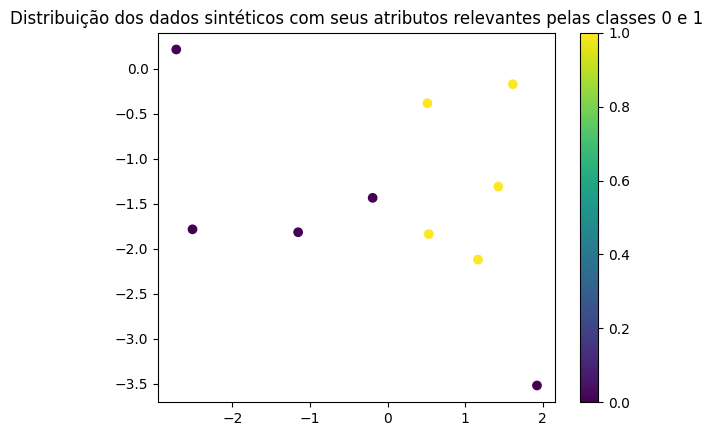

In [3]:
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt

# faz um dataset sintético com 2 atributos relevantes e 2 classes
X, Y = make_classification(n_samples=10, n_features=2, n_redundant=0, random_state=2410, n_informative=2, n_clusters_per_class=1, n_classes=2)

# plota a distribuição das classes
plt.scatter(X[:, 0], X[:, 1], c=Y)
plt.colorbar()
plt.title('Distribuição dos dados sintéticos com seus atributos relevantes pelas classes 0 e 1');

### Treinamento da rede neural com dados sintéticos

In [4]:
NUM_DADOS_DE_ENTRADA = 2
NUM_DADOS_DE_SAIDA = 1
CAMADAS_OCULTAS = [3, 2]

arquitetura_da_rede = CAMADAS_OCULTAS + [NUM_DADOS_DE_SAIDA]

minha_mlp = MLP_classificadora(NUM_DADOS_DE_ENTRADA, arquitetura_da_rede)

In [5]:
NUM_EPOCAS = 20
TAXA_DE_APRENDIZADO = 0.000001

for epoca in range(NUM_EPOCAS):

    # forward pass
    y_pred = []

    for exemplo in X:
        previsao = minha_mlp(exemplo)
        y_pred.append(previsao)

    # loss
    erros = []
    for yt, yp in zip(Y, y_pred):
        yt = Value(yt)
        nll = -(yt * (yp + tol).log() + (1 - yt) * (1 - yp + tol).log())
        erros.append(nll)

    loss = sum(erros) / len(erros)

    # zero grad
    parametros_antes = minha_mlp.parametros()
    for p in minha_mlp.parametros():
        p.grad = 0

    # backpropagation
    loss.propagate_all()

    # atualiza parâmetros
    for p in minha_mlp.parametros():
        p.data = p.data - p.grad * TAXA_DE_APRENDIZADO

    # mostra resultado (opcional)
    print(epoca, loss.data)

0 0.7048716966727403
1 0.7039895829167465
2 0.7031975859076938
3 0.7024758163121239
4 0.7018115576144592
5 0.7011961348767275
6 0.7006232602058221
7 0.7000881215121957
8 0.6995868571965989
9 0.6988204679541078
10 0.6962787856868401
11 0.6938865451697724
12 0.6915795963715781
13 0.6893140327621022
14 0.6870607285352122
15 0.6848020291202709
16 0.6825295348597378
17 0.6817779227497028
18 0.6796050944665393
19 0.6777525034500029


Percebe-se uma redução pequena do valor da perda, que pode ser atribuído a alguma sensibilidade do valor inicial dos parâmetros que não está sendo capturada aqui.

## Aplicando dados reais na rede neural

### Tratamento dos dados

In [6]:
# importações relevantes para essa parte
import pandas as pd
#from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MaxAbsScaler

Definimos que nosso *dataset* seria o "Occupancy Detection", retirado do [UC Irvine Machine Learning Repository](https://archive.ics.uci.edu/dataset/357/occupancy+detection). As colunas são todas numéricas, não apresentam dados faltantes, e são as seguintes:

- Data da medição
- Temperatura (ºC) da sala
- Umidade percentual (%) da sala
- Luz (Lux)
- Quantidade de $CO_2$ (ppm) na sala
- Umidade específica ($\frac{kg_{vapor-de-água}}{kg_{ar}}$) da sala, que mede a quantidade de vapor de água dada uma massa de ar seco.
- Ocupação da sala, em que 0 significa que não está ocupada, e 1 que está.

Dentre as colunas, para evitar trabalhar com séries temporais e entendendo que só precisamos de uma das informações de umidade, escolhemos como atributos: Temperatura; Luz; Quantidade de $CO_2$; e Umidade específica. Nosso *target* será a ocupação da sala.

Abaixo, verificamos o começo do *DataFrame*:

In [7]:
df = pd.read_csv("occupancy_detection.csv")
df_amostra = df.sample(n = 100, random_state=10)
df_amostra.dropna(inplace=True)
df = df_amostra.reset_index(drop=True)
df

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
0,2015-02-13 18:47:00,21.230,32.433333,0.0,534.750000,0.005064,0
1,2015-02-07 00:11:59,20.000,18.790000,0.0,438.000000,0.002709,0
2,2015-02-10 01:52:00,20.290,32.900000,0.0,461.000000,0.004846,0
3,2015-02-17 12:23:59,21.700,32.730000,464.0,1286.333333,0.005261,1
4,2015-02-15 10:23:00,21.890,29.000000,289.0,639.000000,0.004712,0
...,...,...,...,...,...,...,...
95,2015-02-05 21:47:00,20.745,20.390000,0.0,458.500000,0.003080,0
96,2015-02-05 16:53:00,22.290,25.700000,441.0,1045.666667,0.004276,1
97,2015-02-16 15:42:59,21.865,28.972500,449.0,895.000000,0.004700,1
98,2015-02-05 07:34:59,20.700,22.390000,0.0,449.000000,0.003375,0


Nas células a seguir, vamos separar os dados em treino, validação e teste. Utilizaremos o `MaxAbsScaler` para manter os dados entre [-1,1], conservando seu formato principal.

In [8]:
FEATURES = ["Temperature", "Light", "CO2", "HumidityRatio"]
TARGET = ["Occupancy"]
SEED = 10

X = df[FEATURES].values
y = df[TARGET].values

# divide em treino e teste/validação
X_train, X_tv, y_train, y_tv = train_test_split(X, y, test_size=0.4, random_state=SEED)

# divide em teste e validação os valores em X_tv e y_tv
X_test, X_val, y_test, y_val = train_test_split(X_tv, y_tv, test_size=0.5, random_state=SEED)

# normaliza os dados de entrada da rede
scaler = MaxAbsScaler()
scaler.fit(X_train)
X_train_norm = scaler.transform(X_train)
X_val_norm = scaler.transform(X_val)
X_test_norm = scaler.transform(X_test)

### Treinamento da rede neural - dados normalizados

Feita a normalização pelo máximo, demos início ao treinamento da rede neural. A arquitetura escolhida contém duas camadas ocultas, em que a primeira possui 3 neurônios e a segunda, 2.

In [9]:
NUM_DADOS_DE_ENTRADA = len(FEATURES)
NUM_DADOS_DE_SAIDA = 1
CAMADAS_OCULTAS = [3, 2]

arquitetura_da_rede = CAMADAS_OCULTAS + [NUM_DADOS_DE_SAIDA]

minha_mlp = MLP_classificadora(NUM_DADOS_DE_ENTRADA, arquitetura_da_rede)

O treinamento foi realizado por 20 épocas, seguindo uma taxa de aprendizado de 0.01. Como se trata de um problema de classificação, a função de perda utilizada foi a entropia cruzada. Sendo $L_{nll}$ a função de perda, temos:

$$L_{nll}(previsto, verdadeiro) = -(verdadeiro \cdot \log(previsto) + (1 - verdadeiro) \cdot \log(1 - previsto))$$

Segue, abaixo, o treinamento:

In [10]:
NUM_EPOCAS = 40
TAXA_DE_APRENDIZADO = 0.001
losses_treino = []
losses_val = []

for epoca in range(NUM_EPOCAS):

      # forward pass
      y_pred = []
      y_pred_val = []

      for exemplo in X_train_norm:
          previsao = minha_mlp(exemplo)
          y_pred.append(previsao)

      for exemplo in X_val_norm:
          previsao = minha_mlp(exemplo)
          y_pred_val.append(previsao)

      # loss pred e val
      erros = []
      for yt, yp in zip(y_train, y_pred):
          yt = Value(yt)
          nll = -(yt * (yp + tol).log() + (1 - yt + tol) * (1 - yp + tol).log())
          erros.append(nll)

      loss = sum(erros) / len(erros)
      losses_treino.append(loss.data)

      erro_val = []
      for yt, yp in zip(y_val, y_pred_val):
          yt = Value(yt)
          nll = -(yt * (yp + tol).log() + (1 - yt) * (1 - yp + tol).log())
          erro_val.append(nll)

      loss_val = sum(erro_val) / len(erro_val)
      losses_val.append(loss_val.data)

    # zero grad
      parametros_antes = minha_mlp.parametros()
      for p in minha_mlp.parametros():
          p.grad = 0

    # backpropagation
      loss.propagate_all()

    # atualiza parâmetros
      for p in minha_mlp.parametros():
          p.data = p.data - p.grad * TAXA_DE_APRENDIZADO

      # mostra resultado (opcional)
      if epoca % 10 == 0:
          print(epoca, "loss_treino:", loss.data, "loss_val", loss_val.data)

0 loss_treino: [0.78560027] loss_val [0.77131528]


<ipython-input-2-7f5a2bce6bf2>:135: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  data = math.exp(self.data)


10 loss_treino: [2.18677185] loss_val [2.41706467]
20 loss_treino: [2.18677185] loss_val [2.41706467]
30 loss_treino: [2.18677185] loss_val [2.41706467]


Foi possível perceber que a perda chegou a um platô, apesar da taxa de aprendizado estar bem baixa. Vamos verificar a acurácia do modelo.

In [13]:
y_pred = []
for exemplo in X_test_norm:
    previsao = minha_mlp(exemplo)
    if previsao > 0.5:
        y_pred.append(1)
    else:
      y_pred.append(0)

correct = 0
for pred, true in zip(y_pred, y_test):
    if pred == true:
      correct += 1

print('Acurácia:', correct * 100 / len(y_test))

Acurácia: 80.0


<ipython-input-2-7f5a2bce6bf2>:135: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  data = math.exp(self.data)


A acurácia parece impressionante! Vamos verificar frente a um modelo baseline, que prediz apenas os valores que mais aparecem nos dados:

In [16]:
if sum(y_test) / len(y_test) > 0.5:
  baseline = [1] * len(y_test)
else:
  baseline = [0] * len(y_test)

correct = 0
for pred, true in zip(baseline, y_test):
    if pred == true:
      correct += 1

print('Acurácia:', correct * 100 / len(y_test))

Acurácia: 80.0


Estava muito bom para ser verdade... Nosso modelo performa tão bem quanto um modelo baseline.

**Conclusões:**

Nessa tarefa, foi possível compreender o que é necessário modificar para transformar uma rede neural de classificação, modificando a saída para uma função que force os resultados para se manterem entre 0 e 1 e aplicando a função de perda NLL. Nossa rede neural não foi bem sucedida em compreender os dados reais, mas foi possível usar de conhecimentos prévios para afirmar, categoricamente, que ela é ruim.